In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pynwb import NWBFile, NWBHDF5IO

In [2]:
# Specify data path and filename(s)
data_dir = os.path.join('..','data', 'nwb2.0')
fname = '150817_001_ch2-PnevPanResults-170808-190057'

In [3]:
# Read NWB 2.0 file
nwb_io = NWBHDF5IO(os.path.join(data_dir, fname), mode = 'r')
nwbfile = nwb_io.read()

In [4]:
# Extract all trial-based ROI time-series
roi_series = nwbfile.modules.get('Trial-based').data_interfaces.get('deconvolved dF-over-F').roi_response_series

In [5]:
# Display all event-type data are time locked to
for eve in roi_series.keys():
    print(eve)

commitIncorrAl
firstSideTryAl
firstSideTryAl_COM
goToneAl
initToneAl
rewardAl
stimAl_allTrs
stimAl_noEarlyDec
stimOffAl


In [6]:
# Get the ROI trial-based time-series time-locked to "Start tone"
start_tone_roi_tcourse = roi_series.get('initToneAl')
start_tone_ave = np.nanmean(start_tone_roi_tcourse.data, axis=2) # Get trial average
start_tone_tvec = np.array(start_tone_roi_tcourse.timestamps) # Get timestamps

# Get the ROI trial-based time-series time-locked to "Stimulus Onset"
stim_roi_tcourse = roi_series.get('stimAl_noEarlyDec')
stim_ave = np.nanmean(stim_roi_tcourse.data, axis=2) # Get trial average
stim_tvec = np.array(stim_roi_tcourse.timestamps) # Get timestamps

# Get the ROI trial-based time-series time-locked to "Go Tone"
go_tone_roi_tcourse = roi_series.get('goToneAl')
go_tone_ave = np.nanmean(go_tone_roi_tcourse.data, axis=2) # Get trial average
go_tone_tvec = np.array(go_tone_roi_tcourse.timestamps) # Get timestamps

# Get the ROI trial-based time-series time-locked to "1st Commit"
commit_1_tone_roi_tcourse = roi_series.get('firstSideTryAl')
commit_1_tone_ave = np.nanmean(commit_1_tone_roi_tcourse.data, axis=2) # Get trial average
commit_1_tone_tvec = np.array(commit_1_tone_roi_tcourse.timestamps) # Get timestamps

# Get the ROI trial-based time-series time-locked to "2st Commit"
commit_2_tone_roi_tcourse = roi_series.get('rewardAl')
commit_2_tone_ave = np.nanmean(commit_2_tone_roi_tcourse.data, axis=2) # Get trial average
commit_2_tone_tvec = np.array(commit_2_tone_roi_tcourse.timestamps) # Get timestamps

In [16]:
# Obtain inh/exc status of the ROI
roi_tcourse = roi_series.get('initToneAl')
good_roi_mask = roi_tcourse.rois.data
roi_table = roi_tcourse.rois.table
inh_exc = roi_table.get('neuron_type').data[good_roi_mask]

In [9]:
# Sort the ROI time-series based on the latency of the peak activity
def roi_sort_by_peak_latency(roi_tcourse):
    sorted_roi_idx = np.argsort(np.argmax(roi_tcourse,axis = 1))
    return roi_tcourse[sorted_roi_idx,:].copy(), sorted_roi_idx

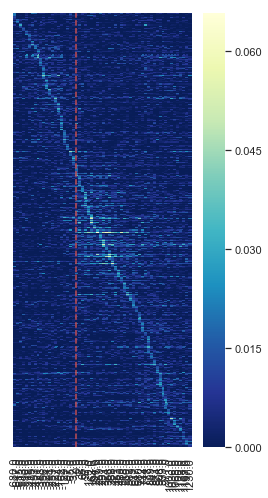

In [10]:
# Raster Plot
sns.set(rc={'figure.figsize':(4,8)})
sorted_roi_tcourse, sorted_idx = roi_sort_by_peak_latency(stim_ave)
sns.heatmap(data = sorted_roi_tcourse,xticklabels = stim_tvec.round(),yticklabels = [],
           cmap = 'YlGnBu_r')
plt.axvline(x= np.where(stim_tvec==0), color='r',linestyle='--',linewidth=1.5)

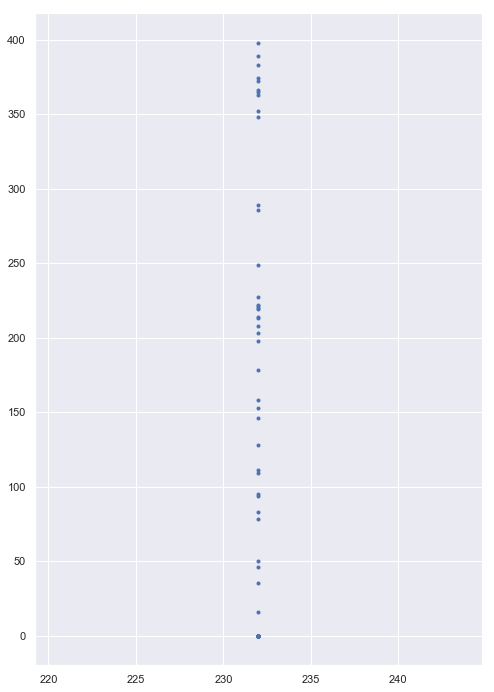

In [37]:
# Sort and concatenate trial-based data time-locked to: start tone, stimulus, 1st commit and 2nd commit
data_all = np.hstack([start_tone_ave, stim_ave, commit_1_tone_ave, commit_2_tone_ave])
data_all, sorted_roi_idx = roi_sort_by_peak_latency(data_all)
xdim_all = [0, start_tone_tvec.size,stim_tvec.size,commit_1_tone_tvec.size,commit_2_tone_tvec.size]
zeros_all = [np.where(v == 0)[0][0] for v in [start_tone_tvec,stim_tvec,commit_1_tone_tvec,commit_2_tone_tvec]]
# inh/exc status:
is_inh = np.zeros((data_all.shape[0]))
is_inh[inh_exc[sorted_roi_idx]=='inhibitory'] = 1
plt.plot(np.ones(is_inh.shape)*(np.cumsum(xdim_all)[-1]),np.arange(is_inh.size)*is_inh,'.')
plt.show()

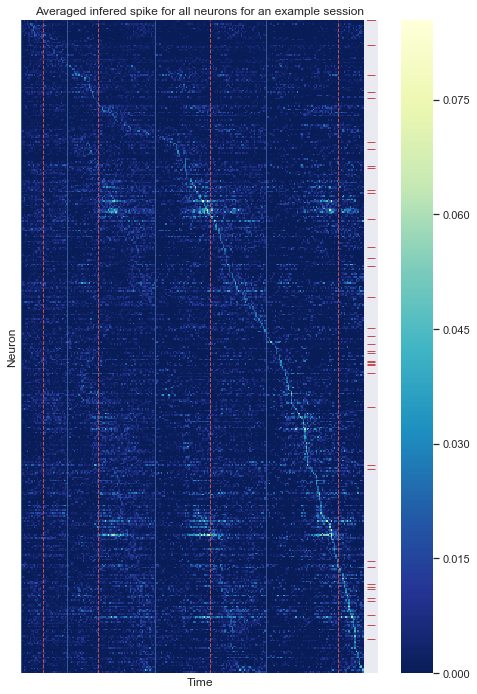

In [63]:
# Raster Plot
sns.set(rc={'figure.figsize':(8,12)})
sns.heatmap(data = data_all,xticklabels = [],yticklabels = [],cmap = 'YlGnBu_r')
# add vertical lines
for zidx, z in enumerate(zeros_all):
    plt.axvline(x= np.cumsum(xdim_all)[zidx], color='b',linestyle='-',linewidth=0.7)
    plt.axvline(x= z + np.cumsum(xdim_all)[zidx], color='r',linestyle='--',linewidth=1)
# add inhibitor marker
plt.plot(np.ones(is_inh.shape)*(data_all.shape[1]+5),np.arange(is_inh.size)*is_inh,'r_',markersize=8)
#
plt.xlim((0,data_all.shape[1]+10))
plt.title('Averaged infered spike for all neurons for an example session')
plt.xlabel('Time')
plt.ylabel('Neuron')
plt.show()